# Improving Performance | Feature Engineering

Update features to train the model.
Run the model on best performing models based on rating from the previous section and XGBoost model.

In [2]:
# Import libraries and shared functions
from helpers import *

In [3]:
# Create a dataframe to store results
res = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

#### Feature Engineering

Due to high evaluation scores, there is a chance of some data leakage - the data that is used for testing is appearing in the training data.
Training a model with leaked data can give an unrealistic score that is not replicated in production.

It's likely that the company won't have satisfaction levels accurately reported for all of its employees. It's also possible that the 'average_monthly_hours' column is a source of some data leakage. If employees have already decided upon quitting, or have already been identified by management as people to be fired, they may be working fewer hours. 

Will modify and/or drop several independent variables to improve the models.

In [5]:
# Import cleaned dataset
df_0 = pd.read_csv("hr_data_encoded.csv")
df_0

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,0.90,0.55,3,259,10,1,0,1,2,0,0,0,0,1,0,0,0,0,0
11987,0.74,0.95,5,266,10,0,0,1,2,0,0,0,0,1,0,0,0,0,0
11988,0.85,0.54,3,185,10,0,0,1,2,0,0,0,0,1,0,0,0,0,0
11989,0.33,0.65,3,172,10,0,0,1,2,0,0,0,0,0,1,0,0,0,0


In [6]:
# Drop 'satisfaction_level' and save resulting dataframe in new variable
df_mod = df_0.drop(columns=['satisfaction_level'])

# Display first few rows of new dataframe
df_mod.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [7]:
# Create 'overworked' column - identical to average monthly hours
df_mod['overworked'] = df_mod['average_monthly_hours']

# Inspect max and min average monthly hours values
print('Max hours:', df_mod['overworked'].max())
print('Min hours:', df_mod['overworked'].min())

Max hours: 310
Min hours: 96


In [8]:
df_mod['overworked'].describe()

count    11991.000000
mean       200.473522
std         48.727813
min         96.000000
25%        157.000000
50%        200.000000
75%        243.000000
max        310.000000
Name: overworked, dtype: float64

166.67 is approximately the average number of monthly hours for a person working 40 hours a week.

Will define being overworked as working more than 170 hours per month on average.
Making 'overworked' a binary variable.

In [9]:
# Define 'overworked' as working > 170 hrs/week
# Create a mask with a series of booleans converted to 0 or 1 
df_mod['overworked'] = (df_mod['overworked'] > 170).astype(int)

df_mod['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int64

In [10]:
# Check the balance of 'overworked' classes
df_mod['overworked'].value_counts()

1    7978
0    4013
Name: overworked, dtype: int64

In [11]:
# Drop the 'average_monthly_hours' column
df_mod = df_mod.drop(columns=['average_monthly_hours'])

df_mod.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [12]:
# Isolate the target variable
y = df_mod['left']

# Select the features
X = df_mod.drop(columns=['left'])

In [13]:
# Create test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=5)

### Modeling Approach E: Decision Tree Model - Round 2

In [48]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=5)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=5, refit='recall')

In [49]:
%%time
tree2.fit(X_train, y_train)

CPU times: user 3.76 s, sys: 86.6 ms, total: 3.85 s
Wall time: 3.88 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=5),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [50]:
# Write pickle
write_pickle(tree2, 'hr_tree2')

# Read pickle
# tree2 = read_pickle('hr_tree2')

In [51]:
# Check best params
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [52]:
# Check best recall score on CV
tree2.best_score_

0.8968305986397611

This model performs well, even without satisfaction levels and detailed hours worked data.

In [53]:
# Get all CV scores
res = make_results('Decision Tree 2 CV', tree2, X_test, y_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree 2 CV,0.960307,0.863724,0.903614,0.883219,0.9584


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

### Modeling Approach F: Random Forest - Round 2

In [54]:
# Instantiate model
rf2 = RandomForestClassifier(random_state=5)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
rf2_cv = GridSearchCV(rf2, cv_params, scoring=scoring, cv=5, refit='recall')

In [55]:
%%time
rf2_cv.fit(X_train, y_train) # ~20 min

CPU times: user 18min 53s, sys: 15.5 s, total: 19min 9s
Wall time: 19min 36s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [56]:
# Write pickle
write_pickle(rf2_cv, 'hr_rf2')

# Read in pickle
#rf2_cv = read_pickle('hr_rf2')

In [57]:
# Check best parameters
rf2_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [58]:
# Check best recall score on CV
rf2_cv.best_score_

0.8934816277973558

In [59]:
# Get all CV scores
res = make_results('Random Forest 2 CV', rf2_cv, X_test, y_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree 2 CV,0.960307,0.863724,0.903614,0.883219,0.958400
1,Random Forest 2 CV,0.955304,0.840824,0.901606,0.870155,0.962004


The scores dropped slightly, but the random forest performs better than the decision tree is all evaluation metrics.

### Modeling Approach G: XGBoost Model

In [14]:
# Instantiate model
xgb = XGBClassifier(objective='binary:logistic', random_state=5) 

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

# Assign a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Instantiate GridSearch
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [15]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 7min 41s, sys: 9.07 s, total: 7min 51s
Wall time: 2min 7s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=5, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [16]:
# Write pickle
write_pickle(xgb_cv, 'hr_xgb')

# Read in pickle
#xgb_cv = read_pickle('hr_xgb')

In [17]:
# Get best parameters of the best model
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 125}

In [64]:
# Get all CV scores
res = make_results('XGBoost CV', xgb_cv, X_test, y_test, res)
res

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree 2 CV,0.960307,0.863724,0.903614,0.883219,0.958400
1,Random Forest 2 CV,0.955304,0.840824,0.901606,0.870155,0.962004
2,XGBoost CV,0.963976,0.890000,0.893574,0.891784,0.970392


XGBoost model has the best performance based on precisionm f1 and AUC score. 
Since XGBoost model has better scores for 4/5 metrics and recall score difference is small, choosing XGBoost as the best performing model for current data set.

### Performance and feature importance analysis

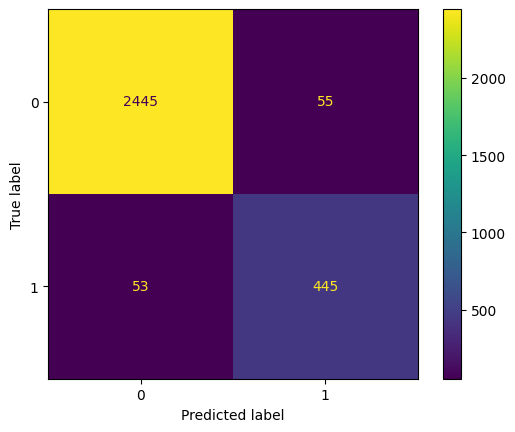

In [21]:
# Generate array of values for confusion matrix for XGBoost model
preds = xgb_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=xgb_cv.classes_)
disp.plot(values_format='');

The model predicts almost the same number of false positives (53) as false negatives (55), which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case and vice versa with the same chances. But this is still a strong model.

#### XGBoost feature importance

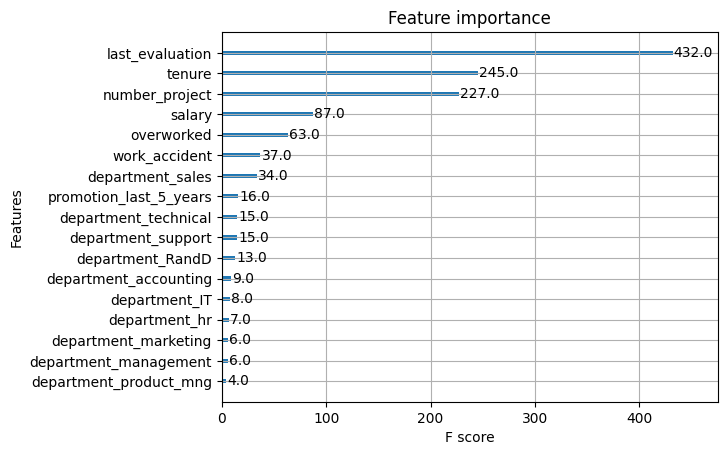

In [23]:
plot_importance(xgb_cv.best_estimator_);

The most important features used by the model are 'last_evaluation', 'tenure', 'number_project', 'salary' and being 'overworked'.

#### Decision tree feature importance

In [67]:
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
number_project,0.395789
last_evaluation,0.334284
tenure,0.169621
overworked,0.094719
department_support,0.002113
salary,0.001039
department_management,0.000748
department_IT,0.000729
department_sales,0.000603
department_accounting,0.000327


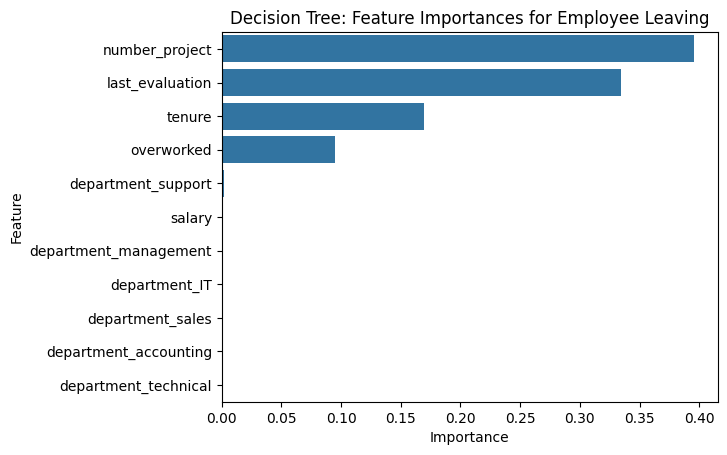

In [68]:
# Create a barplot to visualize the decision tree feature importances.
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

According to the barplot above, for current decision tree model the most important features for predicting 'left' variable are:
'number_project', 'last_evaluation', 'tenure', and being 'overworked' have the highest importance, in that order. 

#### Decision tree splits

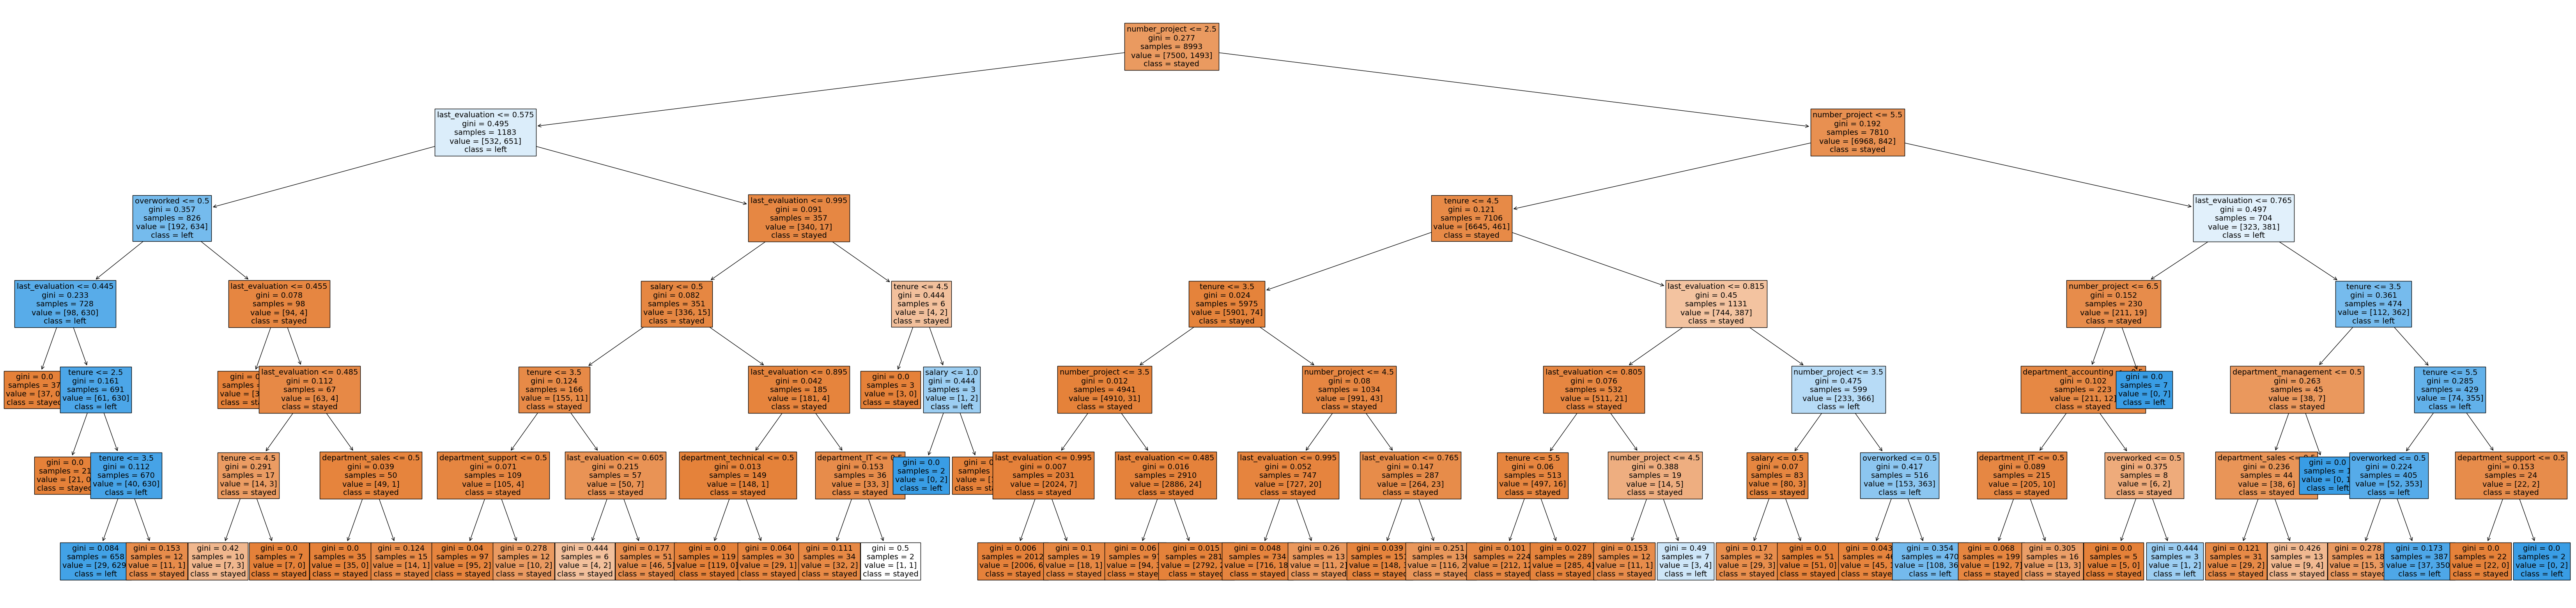

In [69]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

#### Random forest feature importance

Now, plot the feature importances for the random forest model.

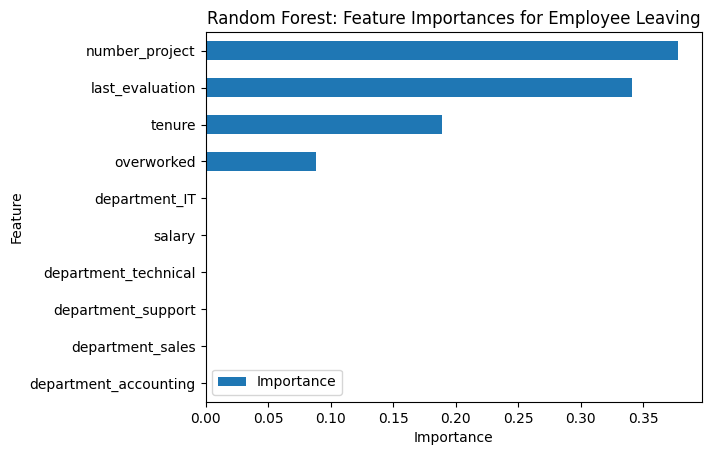

In [70]:
# Get feature importances
feat_impt = rf2_cv.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2_cv.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, 'number_project', 'last_evaluation', 'tenure, and 'overworked' have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, left, and they are the same as the ones used by the XGBoost and decision tree models. XGBoost model also evaluates salary.